<a href="https://colab.research.google.com/github/AISaturdaysLagos/C9-team-solo-alie/blob/main/Project_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CUSTOMER SEGMENTATION PROJECT

A mid-sized retailer aims to replace one-size-fits-all campaigns with targeted growth. Using membership transactions, the business maintains Customer ID, Order ID, Order Date, Quantity, Unit Price and Total Amount. From these, i derive RFM features—Recency (days since last purchase), Frequency (distinct orders) and Monetary (total spend). After cleaning (date parsing, deduplication, removal of returns/negatives), RFM becomes a stable behavioral signal that replaces subjective scoring. The objective is to use unsupervised learning to group customers with similar purchasing patterns and translate each segment into actionable strategies—for example, VIP perks and early access for Champions, cross-sell bundles for Promising, and win-back offers for At-Risk or Hibernating customers. Method: run K-Means (and, if helpful, Gaussian Mixture Models), select the number of clusters with Elbow and Silhouette diagnostics, and profile segments by size and R/F/M levels.

In [4]:
#Import necessary libraries
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

### Sets the project’s working directories—/content/outputs and its figures subfolder—using pathlib, and i creates them if they don’t already exist so later i can save files and plots without path errors.

In [5]:
# Base folder

BASE = Path("/content") # if local. you can use: Path.cwd
OUT = BASE / "outputs"
FIG = OUT/ "figures"

# Create folders if they don't exist
OUT.mkdir(parents=True, exist_ok=True)
FIG.mkdir(parents=True, exist_ok=True)

### I pull the retail transactions dataset from GitHub into a pandas DataFrame and displays the first few rows so it can be easy to confirm it loaded correctly and the columns look right.

In [6]:
#Import Online Retail Data containing transactions
online = pd.read_csv('https://raw.githubusercontent.com/AISaturdaysLagos/C9-team-solo-alie/refs/heads/main/data/retail_sales_dataset.csv', encoding = 'unicode_escape')
online.head()

,Transaction ID,Date,Customer ID,Gender,Age,Product Category,Quantity,Price per Unit,Total Amount
0,1,2023-11-24,CUST001,Male,34,Beauty,3,50,150
1,2,2023-02-27,CUST002,Female,26,Clothing,2,500,1000
2,3,2023-01-13,CUST003,Male,50,Electronics,1,30,30
3,4,2023-05-21,CUST004,Male,37,Clothing,1,500,500
4,5,2023-05-06,CUST005,Male,30,Beauty,2,50,100


### Defines a lookup of canonical column names to their common header variants so i can reliably standardize/rename the dataset’s columns regardless of how they appear in the raw file.

In [7]:
SYNONYMS = {
    "customer_id": ["Customer ID", "Customer_Id"],
    "order_id":    ["Transaction ID"],
    "order_date":  ["Date"],
    "quantity":    ["Quantity"],
    "unit_price":  ["Unit Price", "Price per Unit", "Price"],
    "amount":      ["Total Amount", "Total"]
}

### I define a helper that standardizes column names by matching each existing header (case-insensitively) to the provided synonyms and renaming it to a canonical name, then applies it to the dataset and prints the normalized column list.

In [8]:
def auto_map_columns(df: pd.DataFrame, synonyms: dict) -> pd.DataFrame:
    rename_map = {}
    lower_cols = {c.lower(): c for c in df.columns}
    for target, alts in synonyms.items():
        for a in alts:
            if a in df.columns:
                rename_map[a] = target
                break
            if a.lower() in lower_cols:
                rename_map[lower_cols[a.lower()]] = target
                break
    return df.rename(columns=rename_map)

df = auto_map_columns(online.copy(), SYNONYMS)
df.columns

Index(['order_id', 'order_date', 'customer_id', 'Gender', 'Age',
       'Product Category', 'quantity', 'unit_price', 'amount'],
      dtype='object')

### I returns the dataset’s shape as (rows, columns) so i can quickly verify how many transactions and fields are present.

In [9]:
#Check the number of columns and rows in the dataset
online.shape

(1000, 9)

### I count missing (NaN) values for each column so we can spot which fields need cleaning or imputation.

In [10]:
#Check for missing values in the dataset
online.isnull().sum(axis=0)

,0
Transaction ID,0
Date,0
Customer ID,0
Gender,0
Age,0
Product Category,0
Quantity,0
Price per Unit,0
Total Amount,0


### Validates that required columns exist (else raises an error), coerces order_date to datetime and quantity to numeric for clean calculations, and sets flags (has_amount, has_unitprice) to indicate whether spend fields are available for later steps

In [11]:
required = ["customer_id","order_id","order_date","quantity"]
for col in required:
    if col not in df.columns:
        raise ValueError(f"Missing required column: {col}")

df["order_date"] = pd.to_datetime(df["order_date"], errors="coerce")
df["quantity"]   = pd.to_numeric(df["quantity"], errors="coerce")

has_amount    = "amount" in df.columns
has_unitprice = "unit_price" in df.columns


### Enforce that at least one spend field (amount or unit_price) exists, coerces them to numeric, then derives the missing one—amount = quantity × unit_price or unit_price = amount / quantity (safely handling zero quantities)—otherwise raising a clear error.



In [12]:
if not has_amount and not has_unitprice:
    raise ValueError("Need either 'amount' or 'unit_price' present (or mappable).")

if not has_amount and has_unitprice:
    df["unit_price"] = pd.to_numeric(df["unit_price"], errors="coerce")
    df["amount"] = df["quantity"] * df["unit_price"]

if has_amount and not has_unitprice:
    df["amount"] = pd.to_numeric(df["amount"], errors="coerce")
    denom = df["quantity"].replace(0, np.nan)
    df["unit_price"] = df["amount"] / denom

### Drop rows missing key fields, removes returns or non-positive quantities/spend, standardizes customer_id and order_id to strings, and then previews the cleaned transactions.

In [13]:
df = df.dropna(subset=["customer_id","order_id","order_date","quantity","amount"])
df = df[(df["quantity"] > 0) & (df["amount"] > 0)]
df["customer_id"] = df["customer_id"].astype(str)
df["order_id"]    = df["order_id"].astype(str)

df.head()

,order_id,order_date,customer_id,Gender,Age,Product Category,quantity,unit_price,amount
0,1,2023-11-24,CUST001,Male,34,Beauty,3,50,150
1,2,2023-02-27,CUST002,Female,26,Clothing,2,500,1000
2,3,2023-01-13,CUST003,Male,50,Electronics,1,30,30
3,4,2023-05-21,CUST004,Male,37,Clothing,1,500,500
4,5,2023-05-06,CUST005,Male,30,Beauty,2,50,100


In [14]:
#Check the shape (number of columns and rows) in the dataset after data is cleaned
online.shape

(1000, 9)

### Print the earliest and latest order_date in the cleaned data to confirm the transaction date range and anchor the Recency reference window.

In [15]:
print('Min:{}; Max:{}'.format(min(df.order_date),
max(df.order_date)))

Min:2023-01-01 00:00:00; Max:2024-01-01 00:00:00


# RFM (Recency , Frequency, Monetary) Computation

This section computes per-customer RFM features—Recency (days since last purchase relative to a reference date), Frequency (count of distinct orders), and Monetary (total spend)—by grouping transactions by customer to produce a one-row-per-customer RFM table for clustering.

### Set the RFM reference ‘snapshot’ date to one day after the most recent order, so each customer’s Recency is measured as the days between their last purchase and this fixed point.

In [16]:
# "Today" snapshot = 1 day after the latest order in the dataset
snapshot = df["order_date"].max() + timedelta(days=1)

### Group transactions by customer to compute last purchase date, distinct order count, and total spend, converts that date into Recency in days relative to the snapshot, drops the helper column, and returns a tidy RFM table with [recency_days, orders_count, total_spend] ready for modeling.

In [17]:
# Aggregate per customer

rfm = (
    df.groupby("customer_id").agg(
        last_purchase=("order_date","max"), # Most recent purchase date (Recency)
        orders_count=("order_id","nunique"),  # number of distinct orders (Frequecy)
        total_spend=("amount","sum") # total money spent (Monetary)
    )

    # Compute Recency in days: small = good (they bought recently)

    .assign(recency_days=lambda x: (snapshot - x["last_purchase"]).dt.days)

    # Drop helper column we no longer need

    .drop(columns="last_purchase")

    # Reorder colums for readabilty
    .loc[:, ["recency_days", "orders_count", "total_spend"]]
)

### Filter the RFM table to valid customers only—keeping rows where recency is non-negative, orders_count ≥ 1, and total_spend > 0—to remove artifacts from bad dates, duplicates, or returns.

In [18]:

# Guard-rails: keep only valid customers
rfm = rfm[(rfm["recency_days"] >= 0) &  #recency cannot be negative
      (rfm["orders_count"] > 0) &  # must have at least 1 order
       (rfm["total_spend"] > 0) # and must have spent something
    ]

### Print clear definitions for each RFM column and shows the first five rows of the RFM table so i can quickly verify that the values look correct and interpretable.

In [19]:
print("RFM column definitons:")
print (" - recency_days: days since the customer's last purchase (lower is better)")
print (" - orders_count: number of distinct orders per customer (higher is better)")
print (" - total_spend: total amount spent by the customer (dataset currency)")

print("\nSample (first 5 customers):")
display(rfm.head())

RFM column definitons:
 - recency_days: days since the customer's last purchase (lower is better)
 - orders_count: number of distinct orders per customer (higher is better)
 - total_spend: total amount spent by the customer (dataset currency)

Sample (first 5 customers):


,recency_days,orders_count,total_spend
customer_id,,,
CUST001,39,1,150
CUST002,309,1,1000
CUST003,354,1,30
CUST004,226,1,500
CUST005,241,1,100


### Computes and displays descriptive stats for the RFM table—renaming entries (e.g., count→count_customers, mean→mean_value)—so i can see typical values, spread, and quartiles for recency_days, orders_count, and total_spend.

In [20]:
print("\nDescriptive statistics:")
display(rfm.describe().rename(index={
    "count" : "count_customers",
    "mean" : "mean_value",
    "std" : "std_dev",
    "min" : "min_value",
    "25%" : "q1",
    "50%" : "median",
    "75%" : "q3",
    "max" : "max_value"
 }))


Descriptive statistics:


,recency_days,orders_count,total_spend
count_customers,1000.000000,1000.0,1000.000000
mean_value,182.982000,1.0,456.000000
std_dev,105.276773,0.0,559.997632
min_value,1.000000,1.0,25.000000
q1,90.000000,1.0,60.000000
median,186.500000,1.0,135.000000
q3,269.000000,1.0,900.000000
max_value,366.000000,1.0,2000.000000


# K search (Elbow & Silhouette), Choose best k

This section searches for the best number of clusters by fitting K-Means across several k values, plotting inertia (Elbow) and computing silhouette scores, then selecting the smallest k past the elbow that also has a high silhouette.

### Builds a flexible map that accepts either naming style for R/F/M (e.g., recency or recency_days, frequency or orders_count, monetary or total_spend) and verifies that the expected columns actually exist in rfm, raising a clear error if any are missing.

In [21]:
# Map colum names

col_map = {
    "recency_days": "recency" if "recency" in rfm.columns else "recency_days",
    "orders_count": "frequency" if "frequency" in rfm.columns else "orders_count",
    "total_spend":  "monetary" if "monetary" in rfm.columns else "total_spend"
}
for k, v in col_map.items():
    if v not in rfm.columns:
        raise KeyError(f"Expected RFM column not found: {v}")


### Select the R, F, and M columns (using the flexible map), copies them into the modeling matrix X, and standardizes the headers to recency, frequency, and monetary so the next scaling/clustering steps can use a clean, consistent feature set.bold text

In [22]:
# Build features matrix (R, F, M)

X = rfm[[col_map["recency_days"], col_map["orders_count"], col_map["total_spend"]]].copy()
X.columns = ["recency", "frequency", "monetary"] # standardize label for readability
# X.head()

### Reduce Monetary skew with a log1p transform and scales all R/F/M features using RobustScaler to produce X_scaled for clustering, preventing outliers and big spenders from dominating distances.

In [23]:
# Transform & scale
X["monetary"] = np.log1p(X["monetary"]) # compress skew so cluster aren't dominated by big spenders
X_scaled = RobustScaler().fit_transform(X)

### Loop over candidate k values (2–8), fits K-Means on the scaled RFM features, records Elbow (inertia) and Silhouette scores, tracks the k with the highest Silhouette, and prints the suggested best k (handling any cases where Silhouette can’t be computed).

In [24]:
# Range of k and record metrics
ks = range(2,9)
inertias, silhouettes = [], [] # lists to collect metrics for each k
best_k, best_sil = None, -1 # track the best k and it silhouette

for k in ks:
  km = KMeans(n_clusters=k, n_init=20, random_state=42)
  labels = km.fit_predict(X_scaled)
  inertias.append(km.inertia_) # Elbow meteric: lower is bettter, but with diminishing returns

  try:
    sil = silhouette_score(X_scaled, labels) # Silhouette: -1..+1 where
  except Exception:
    sil = np.nan
  silhouettes.append(sil)

  if not np.isnan(sil) and sil > best_sil:
    best_k, best_sil = k, sil


print (f'Suggest best k (by Silhouette): {best_k} | Silhouteete = {best_sil:.4f}' if best_k else "No valid Silhouette found")

Suggest best k (by Silhouette): 4 | Silhouteete = 0.4581


### Compile the k-search diagnostics into a tidy table—listing each k alongside its inertia and silhouette score—and displays it with simple formatting so i can compare clustering options at a glance.

In [25]:
# Making a compact result table
ksearch = pd.DataFrame({
    "k": list(ks),
    "inertia": inertias,
    "silhouette": silhouettes

})
display (ksearch.style.format({"inertia": "{:.4f}"}))


,k,inertia,silhouette
0,2,331.7122,0.397021
1,3,212.6850,0.424821
2,4,131.3456,0.458148
3,5,106.8027,0.416464
4,6,87.1126,0.407543
5,7,73.8378,0.392740
6,8,65.8047,0.392234


# Plot Elbow & Silhouette

This cell plots the Elbow curve (inertia vs. k) and Silhouette scores vs. k so you can see where added clusters stop improving fit and which k gives the strongest separation.

### Plots inertia against k to visualize the Elbow curve, saves the figure to FIG/elbow.png, and displays it so you can spot where adding clusters yields diminishing returns.

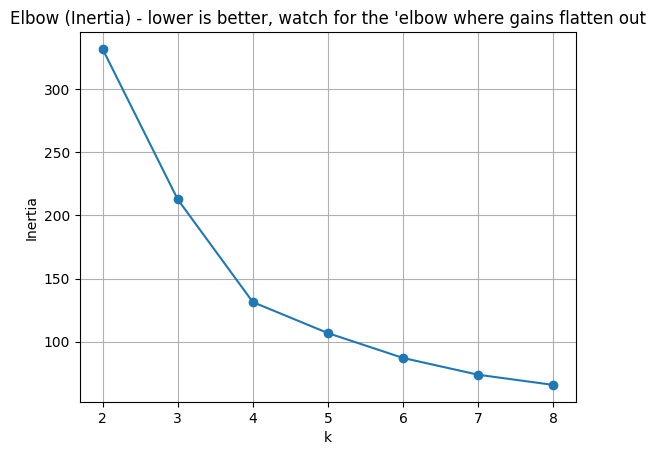

In [26]:
# Plot Elbow
plt.figure()
plt.plot(list(ks), inertias, marker="o")
plt.title("Elbow (Inertia) - lower is better, watch for the 'elbow where gains flatten out")
plt.xlabel("k");
plt.ylabel("Inertia");
plt.grid(True)
plt.savefig(FIG / "elbow.png", bbox_inches="tight");
plt.show()

### Plot the silhouette score for each k (higher is better for well-separated clusters), saves the chart to FIG/silhouettes.png, and displays it to help pick the most separable number of clusters.

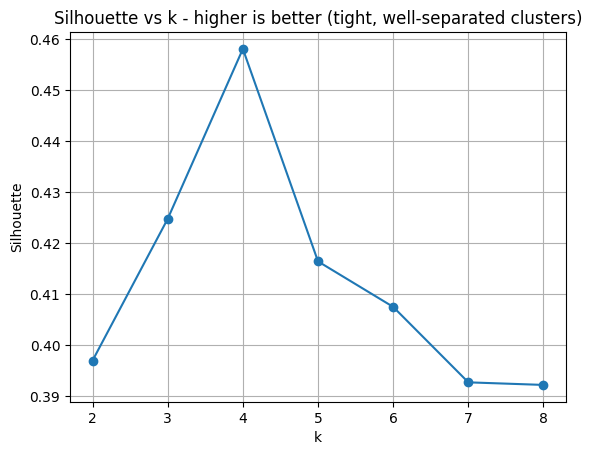

In [27]:
# Plot Silhouettes

plt.figure()
plt.plot(list(ks), silhouettes, marker="o")
plt.title("Silhouette vs k - higher is better (tight, well-separated clusters)")
plt.xlabel("k");
plt.ylabel("Silhouette");
plt.grid(True)
plt.savefig(FIG / "silhouettes.png", bbox_inches="tight");
plt.show()

### I write the k-search diagnostics (k, inertia, silhouette) to outputs/KSEARCH.csv so the model-selection results can be archived, shared, and cited in the appendix.

In [28]:
# saving the k-search results as CSV (nice for appendix)

ksearch.to_csv(OUT / "KSEARCH.csv", index=False)

### I print a short guide on how to read the Elbow and Silhouette charts and, if available, announces the chosen number of clusters k based on the highest Silhouette score for the next modeling step.

In [29]:
# Chart explanation

print("\nChart explanation:")
print("- Elbow (Inertia): 'I increase k until the improvement (drop in inertia) flattens - that's the elbow'")
print ("- Silhouette: 'I choose the k with the highest score, meaning clusters are compact and well-separated'")
if best_k:
  print (f"\nDecision: I will proceed with k={best_k} (best Silhouette={best_sil:.4f}) and verify it also makes business sense.")



Chart explanation:
- Elbow (Inertia): 'I increase k until the improvement (drop in inertia) flattens - that's the elbow'
- Silhouette: 'I choose the k with the highest score, meaning clusters are compact and well-separated'

Decision: I will proceed with k=4 (best Silhouette=0.4581) and verify it also makes business sense.


# Final KMean wth best_k

This section fits the final K-Means model using best_k, assigns each customer a cluster label, and joins the labels back to the RFM table to prepare for persona mapping and EDA.

In [30]:
# Choose the final number of clusters

k_final = best_k if best_k is not None else 3

# Fit KMeans again but this time for real, with chosen k

km = KMeans(n_clusters=k_final, n_init=20, random_state=42).fit(X_scaled)

# Make a copy of the RFM table (to keep  original data safe)
rfm = rfm.copy()

# Add each customer's cluster label (segment number)
# Example: 0, 1, 2, 3, ...... depending on which group they belong to

rfm["segment"] = km.labels_

### Map the desired R/F/M names to whatever columns actually exist in rfm (falling back to recency_days, orders_count, total_spend if needed) and validates each mapping, raising a clear error if any required column is missing.

In [31]:
col_map = {
    "recency": "recency" if "recency" in rfm.columns else "recency_days",
    "frequency": "frequency" if "frequency" in rfm.columns else "orders_count",
    "monetary": "monetary" if "monetary" in rfm.columns else "total_spend"
}

for want, have in col_map.items():
    if have not in rfm.columns:
        raise KeyError(f"Expected RFM column not found: want '{want}' mapped to '{have}' ")

### I standardizes the RFM column names by renaming them to recency, frequency, and monetary (based on the earlier map) and copies the result to rfm_std so downstream modeling and plots use consistent headers.

In [32]:
rfm_std = rfm.rename(columns ={
    col_map["recency"]: "recency",
    col_map["frequency"]: "frequency",
    col_map["monetary"]: "monetary"
}).copy()

### Summary of each segment

I summarize customers by segment—calculating each group’s size and share plus mean Recency, Frequency, and Monetary—then sorts largest first and rounds values for readability

In [34]:
summary = (
    rfm_std.groupby("segment")
    .agg(
        size = ("segment", "size"), # how many customers in the group
        recency_mean = ("recency", "mean"), # average recency (how recently they bought)
        frequency_mean = ("frequency", "mean"), # average frequency (how often they buy)
        monetary_mean = ("monetary", "mean"), # average monetary (how much they spend)
    )
    .assign(size_pct = lambda d: 100 * d["size"] / d["size"].sum()) # percentage of total
    .sort_values("size", ascending=False)                           # biggest group first
    .round({"recency_mean": 1, "frequency_mean": 2, "moneytary_mean": 2, "size_pct": 2})
)

### GIVE EACH CLUSTER A HUMAN-READABLE PERSONA

Rank cluster by mean Recency (lower is better), Frequency and Monetary (higher is better), builds a robust persona_map from the ranked order (auto-extending labels if clusters exceed the base list), applies persona names to rfm, rfm_std, and summary, and displays the final segmentation profile.

In [35]:
# Rank clusters by R/F/M - Recenct lower is better, Frequency & Monetary higher are better.

# Rank by recency (lower = better)
r_rank = rfm_std.groupby("segment")["recency"].mean().rank(ascending=True)

# Rank by frequency (higher = better)
f_rank = rfm_std.groupby("segment")["frequency"].mean().rank(ascending=False)

# Rank by monetary (higher = better)
m_rank = rfm_std.groupby("segment")["monetary"].mean().rank(ascending=False)


# Combine the three ranks into a single score
score = (r_rank + f_rank + m_rank).sort_values()


# Assign names to segments based on overall score

# Build persona_map robustly from your score index
base_labels = ["Champions", "Loyal", "Promising", "At Risk", "Hibernating"]
base_labels = [x.strip() for x in base_labels] # remove accidental spaces

# if there is more clustter than labels, auto-extend with Segment_{i}
if len(score.index) > len(base_labels):
  extra = [f"Segment_{i}" for i in range(len(base_labels), len(score.index))]
  names = base_labels + extra
else:
  names = base_labels[:len(score.index)]

  persona_map = {seg: name for seg, name in zip(score.index, names)}

# Apply these names to your dataset
rfm["persona"] = rfm["segment"].map(persona_map)
rfm_std["persona"] = rfm_std["segment"].map(persona_map)
summary["persona"] = summary.index.map(persona_map)

#  Display the summary table - your final segnmentation profile

summary

,size,recency_mean,frequency_mean,monetary_mean,size_pct,persona
segment,,,,,,
0,307,273.7,1.0,86.693811,30.7,At Risk
1,297,91.7,1.0,89.175084,29.7,Promising
3,203,271.3,1.0,1036.453202,20.3,Loyal
2,193,86.3,1.0,997.409326,19.3,Champions


### Save outputs (CSVs + figures) and quick bar chart

Standardizes RFM column names, sets the index to customer_id, merges R/F/M with cluster labels to build a customer-level segments table, backfills any missing persona names, saves SEGMENTS.csv, SEGMENT_SUMMARY.csv, and KSEARCH.csv, and the preview confirms the structure (customer_id, segment, persona, recency, frequency, monetary)—e.g., CUST001 is Promising with 39 days since last purchase, 1 order, and 150 spent.

In [36]:
# Standardize RFM column names (maps whatever you used in Step 4) ---
col_map = {
    "recency":   "recency"     if "recency"     in rfm.columns else "recency_days",
    "frequency": "frequency"   if "frequency"   in rfm.columns else "orders_count",
    "monetary":  "monetary"    if "monetary"    in rfm.columns else "total_spend",
}
for want, have in col_map.items():
    if have not in rfm.columns:
        raise KeyError(f"Expected RFM column not found: want '{want}' mapped to '{have}'. "
                       f"Your columns: {rfm.columns.tolist()}")

# Create a standardized copy with columns named recency/frequency/monetary
rfm_std = rfm.rename(columns={
    col_map["recency"]: "recency",
    col_map["frequency"]: "frequency",
    col_map["monetary"]: "monetary"
}).copy()

# Ensure index is named customer_id for clarity
if rfm_std.index.name != "customer_id":
    rfm_std.index.name = "customer_id"



# Build SEGMENTS using a MERGE on customer_id
left  = rfm_std.reset_index()[["customer_id", "recency", "frequency", "monetary"]]
right = rfm[["segment", "persona"]].reset_index()  # segment and persona live on original rfm


segments = left.merge(right, on="customer_id", how="left")

segments = segments[["customer_id", "segment", "persona", "recency", "frequency", "monetary"]]

if segments["persona"].isna().any():
  segments["persona"] = segments.apply(
      lambda r: persona_map.get(r["segment"], f"Segment_{int(r['segment'])}"), axis=1
  )

segments.to_csv(OUT/ "SEGMENTS.csv", index=False)

# Save segment summary table
summary.to_csv(OUT/ "SEGMENT_SUMMARY.csv")

# Save K Search table (Elbow & Silhouette across tested k)
pd.DataFrame({
    "k": list(ks),
    "inertia": inertias,
    "silhouette": silhouettes
}).to_csv(OUT / "KSEARCH.csv", index=False)


segments.head()

,customer_id,segment,persona,recency,frequency,monetary
0,CUST001,1,Promising,39,1,150
1,CUST002,3,Loyal,309,1,1000
2,CUST003,0,At Risk,354,1,30
3,CUST004,3,Loyal,226,1,500
4,CUST005,0,At Risk,241,1,100


# BEAUTIFIED CUSTOMER SEGMENTATION **EDA**

### This section previews the customer-level RFM + labels table (indexed by customer_id), reports the shape (1000×5) and confirms no missing values, then generates polished EDA visuals—count and pie charts of persona sizes, bar charts of average R/F/M, boxplots of recency/monetary, histograms, and a correlation heatmap—to reveal segment differences, saving all figures to FIG/.

In [37]:
# Clean Visual style
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams["axes.edgecolor"] = "gray"
plt.rcParams["axes.linewidth"] = 0.8
plt.rcParams["figure.facecolor"] = "white"


# Color Palette
palette = sns.color_palette("Set2")
persona_order = ["Champions", "Loyal", "Promising", "At Risk", "Hibernating"]


# Copy
eda_df = rfm_std.copy()

# Overview
print("=== Data Overview ===")
display(eda_df.head())
print(f"Shape: {eda_df.shape}")
print("\nMissing values: \n", eda_df.isna().sum())

=== Data Overview ===


,recency,frequency,monetary,segment,persona
customer_id,,,,,
CUST001,39,1,150,1,Promising
CUST002,309,1,1000,3,Loyal
CUST003,354,1,30,0,At Risk
CUST004,226,1,500,3,Loyal
CUST005,241,1,100,0,At Risk


Shape: (1000, 5)

Missing values: 
 recency      0
frequency    0
monetary     0
segment      0
persona      0
dtype: int64


### Customer Count per Persona

Build a seaborn count plot of customers per persona in the specified order, annotates each bar with its exact count, applies readable titles/axes/rotation, saves the figure to FIG/customer_count_per_persona.png, and displays it.

/tmp/ipython-input-676267451.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="persona", data=eda_df, order=persona_order, palette=palette)
/tmp/ipython-input-676267451.py:2: UserWarning: The palette list has more values (8) than needed (5), which may not be intended.
  sns.countplot(x="persona", data=eda_df, order=persona_order, palette=palette)


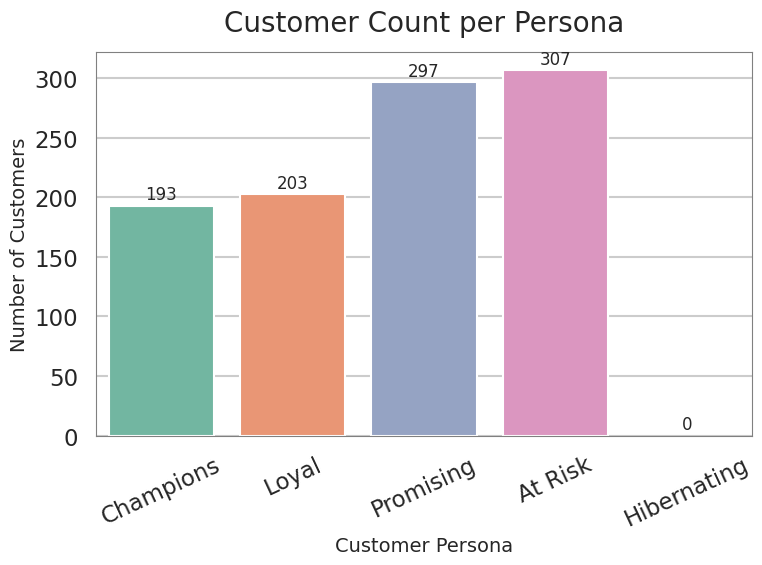

In [38]:
plt.figure(figsize=(8, 6))
sns.countplot(x="persona", data=eda_df, order=persona_order, palette=palette)
plt.title("Customer Count per Persona", fontsize=20, pad=15)
plt.xlabel("Customer Persona", fontsize=14)
plt.ylabel("Number of Customers", fontsize=14)
for i, v in enumerate(eda_df["persona"].value_counts().reindex(persona_order).fillna(0).astype(int)):
    plt.text(i, v + 2, str(v), ha="center", va="bottom", fontsize=12)
plt.xticks(rotation=25)
plt.tight_layout()
plt.savefig(FIG / "customer_count_per_persona.png", bbox_inches="tight")
plt.show()

### Personal Distribution (Pie Chart)

Chart the percentage share of each persona by computing value counts in a fixed order, plotting a labeled pie (starting at 90°) with the chosen palette, then saving it to FIG/persona_distribution.png and displaying the figure.

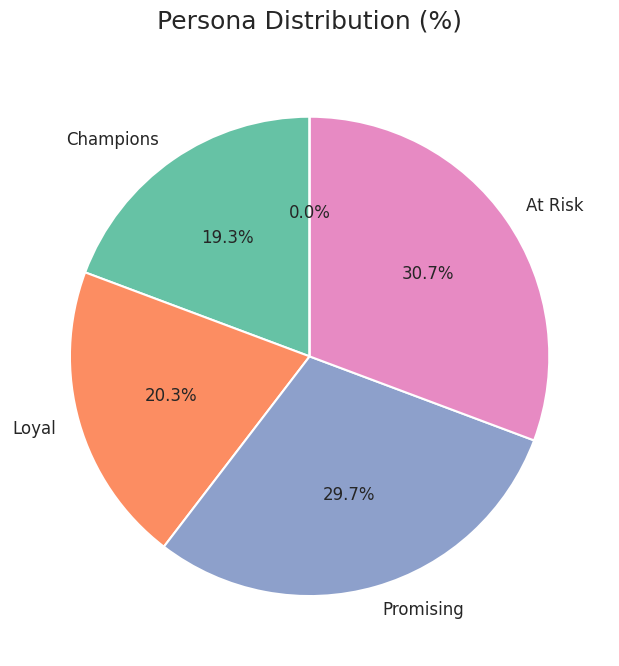

In [39]:
plt.figure(figsize=(7, 7))
eda_df["persona"].value_counts().reindex(persona_order).plot.pie(
    autopct="%1.1f%%",
    startangle=90,
    colors=palette,
    textprops={"fontsize": 12}
)
plt.title("Persona Distribution (%)", fontsize=18, pad=20)
plt.ylabel("")
plt.tight_layout()
plt.savefig(FIG / "persona_distribution.png", bbox_inches="tight")
plt.show()

### Average RFM Metrics per Persona

Group customers by persona to compute the mean Recency, Frequency, and Monetary, prints the summary in a fixed order, and plots a grouped bar chart comparing those averages—saving it to FIG/average_rfm_by_persona.png—showing here that Champions/Loyal have the highest spend, Promising/At Risk are lower with contrasting recency, and Hibernating has no members (NaN).

=== Average RFM Metrics per Persona ===


,recency,frequency,monetary
persona,,,
Champions,86.25,1.0,997.41
Loyal,271.26,1.0,1036.45
Promising,91.72,1.0,89.18
At Risk,273.71,1.0,86.69
Hibernating,NaN,NaN,NaN


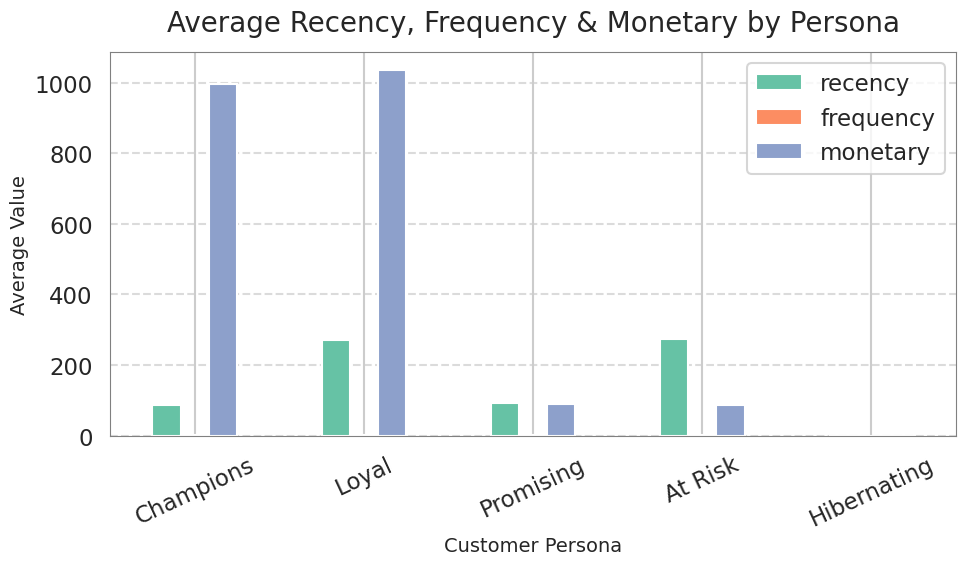

In [40]:
rfm_summary = (
    eda_df.groupby("persona")[["recency", "frequency", "monetary"]]
    .mean()
    .round(2)
    .reindex(persona_order)
)

print("=== Average RFM Metrics per Persona ===")
display(rfm_summary)

rfm_summary.plot(kind="bar", figsize=(10, 6), color=palette)
plt.title("Average Recency, Frequency & Monetary by Persona", fontsize=20, pad=15)
plt.ylabel("Average Value", fontsize=14)
plt.xlabel("Customer Persona", fontsize=14)
plt.xticks(rotation=25)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig(FIG / "average_rfm_by_persona.png", bbox_inches="tight")
plt.show()

### Correlation Heatmap

Compute the correlation matrix for recency, frequency, and monetary, renders it as an annotated heatmap for quick relationship checks, saves it to FIG/correlation_heatmap.png, and displays the figure.

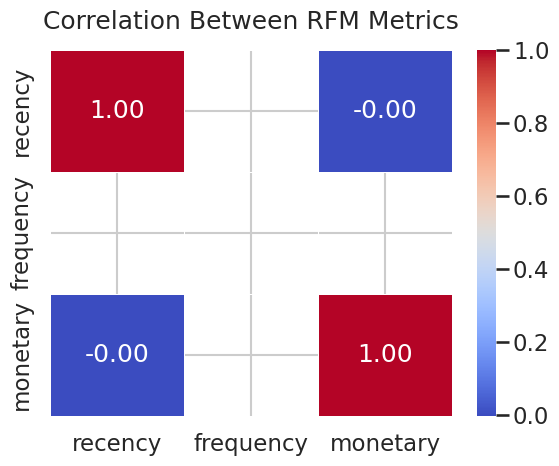

In [41]:
plt.figure(figsize=(6, 5))
sns.heatmap(
    eda_df[["recency", "frequency", "monetary"]].corr(),
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5
)
plt.title("Correlation Between RFM Metrics", fontsize=18, pad=15)
plt.tight_layout()
plt.savefig(FIG / "correlation_heatmap.png", bbox_inches="tight")
plt.show()

### Distribution of R, F, M

Plot side-by-side histograms with KDE overlays for recency, frequency, and monetary to show their distributions (range, skew, outliers), then saves the figure to FIG/distribution_of_rfm.png and displays it.

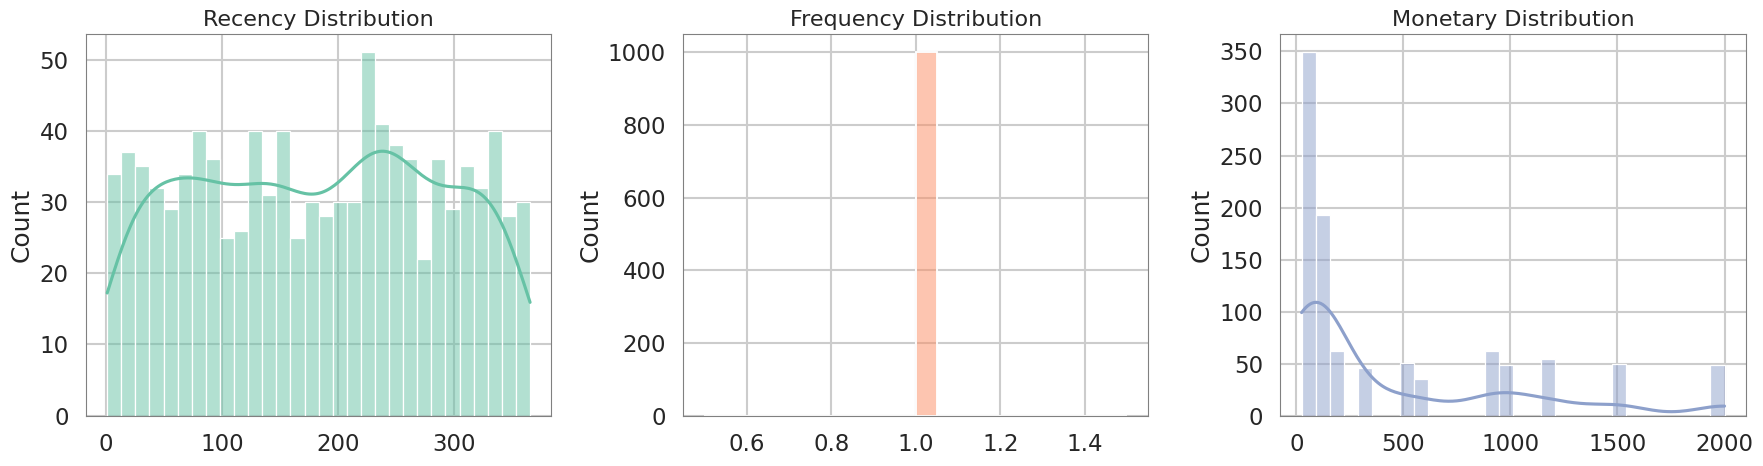

In [42]:
fig, axes = plt.subplots(1,3, figsize=(18, 5))
sns.histplot(data=eda_df["recency"], bins=30, kde=True, ax=axes[0], color=palette[0])
sns.histplot(data=eda_df["frequency"], bins=20, kde=True, ax=axes[1], color=palette[1])
sns.histplot(data=eda_df["monetary"], bins=30, kde=True, ax=axes[2], color=palette[2])

axes[0].set_title("Recency Distribution", fontsize=16)
axes[1].set_title("Frequency Distribution", fontsize=16)
axes[2].set_title("Monetary Distribution", fontsize=16)

for ax in axes:
  ax.set_xlabel("")
plt.tight_layout()
plt.savefig(FIG / "distribution_of_rfm.png", bbox_inches="tight")
plt.show()

### Monetary Distribution by Persona

Plot a boxplot of customer spending (Monetary) for each persona to compare medians, spread, and outliers across segments, saves it to FIG/monetary_distribution_by_persona.png, and displays the figure

/tmp/ipython-input-898128000.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="persona", y="monetary", data=eda_df, order=persona_order, palette=palette)
/tmp/ipython-input-898128000.py:2: UserWarning: The palette list has more values (8) than needed (5), which may not be intended.
  sns.boxplot(x="persona", y="monetary", data=eda_df, order=persona_order, palette=palette)


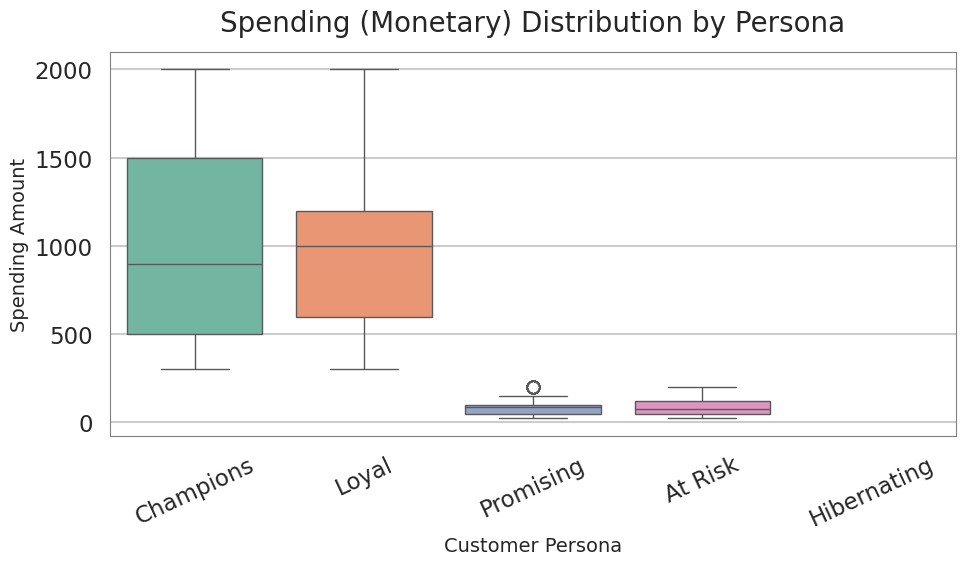

In [43]:
plt.figure(figsize=(10, 6))
sns.boxplot(x="persona", y="monetary", data=eda_df, order=persona_order, palette=palette)
plt.title("Spending (Monetary) Distribution by Persona", fontsize=20, pad=15)
plt.xlabel("Customer Persona", fontsize=14)
plt.ylabel("Spending Amount", fontsize=14)
plt.xticks(rotation=25)
plt.tight_layout()
plt.savefig(FIG / "monetary_distribution_by_persona.png", bbox_inches="tight")
plt.show()

### Recency Distribution by Persona

Plots a boxplot of recency (days since last purchase) for each persona—so you can compare medians, spread, and outliers across segments (lower is more recent)—then saves it to FIG/recency_distribution_by_persona.png and displays the figure.

/tmp/ipython-input-1831460040.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="persona", y="recency", data=eda_df, order=persona_order, palette=palette)
/tmp/ipython-input-1831460040.py:2: UserWarning: The palette list has more values (8) than needed (5), which may not be intended.
  sns.boxplot(x="persona", y="recency", data=eda_df, order=persona_order, palette=palette)


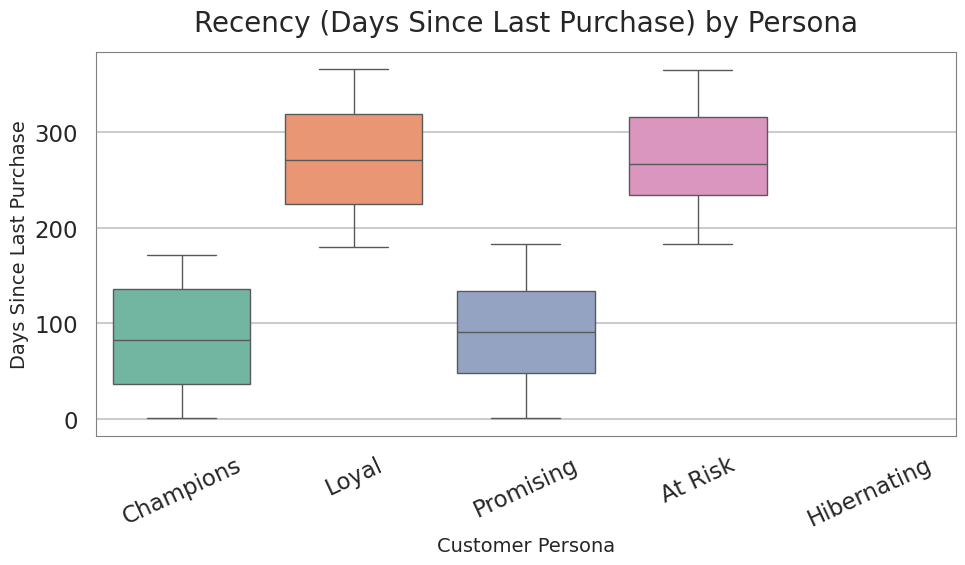

In [44]:
plt.figure(figsize=(10, 6))
sns.boxplot(x="persona", y="recency", data=eda_df, order=persona_order, palette=palette)
plt.title("Recency (Days Since Last Purchase) by Persona", fontsize=20, pad=15)
plt.xlabel("Customer Persona", fontsize=14)
plt.ylabel("Days Since Last Purchase", fontsize=14)
plt.xticks(rotation=25)
plt.tight_layout()
plt.savefig(FIG / "recency_distribution_by_persona.png", bbox_inches="tight")
plt.show()

## INSIGHT SUMMARY OF EDA

The analysis identified five customer segments based on purchasing behavior: Champions, Loyal, Promising, At Risk, and Hibernating.

Among these, At Risk (30.7%) and Promising (29.7%) customers represent the largest groups, indicating that while a significant number of customers show potential, many have recently become inactive.

The Champions (19.3%) and Loyal (20.3%) customers form the brand’s most valuable and consistent base — they purchase more frequently, spend more, and engage more often. These customers should be prioritized for reward programs and personalized offers to maintain loyalty and boost retention.

The Hibernating group currently shows no activity in this dataset, suggesting that these customers have either stopped purchasing or there is insufficient data to track them. Re-engagement campaigns could be targeted here once updated transaction data is available.

Overall, customer spending (monetary) ranges between 25 and 2000, while the recency of purchase spans from 1 to 366 days, showing a diverse mix of customer activity levels. Frequency remains constant at 1 for most customers, which may indicate that most transactions represent single purchases — highlighting an opportunity to increase repeat buying.

In [45]:
print("\n=== KEY INSIGHTS ===")
total_customers = eda_df.shape[0]
segment_count = eda_df["persona"].value_counts().reindex(persona_order)
segment_percent = (segment_count / total_customers * 100).round(1)

for persona, pct in segment_percent.items():
    print(f"{persona}: {pct}% of customers")


print(f"\nTotal Customers: {total_customers}")
print(f"Monetary Range: {eda_df['monetary'].min()} - {eda_df['monetary'].max()}")
print(f"Recency Range: {eda_df['recency'].min()} - {eda_df['recency'].max()}")
print(f"Frequency Range: {eda_df['frequency'].min()} - {eda_df['frequency'].max()}")




=== KEY INSIGHTS ===
Champions: 19.3% of customers
Loyal: 20.3% of customers
Promising: 29.7% of customers
At Risk: 30.7% of customers
Hibernating: nan% of customers

Total Customers: 1000
Monetary Range: 25 - 2000
Recency Range: 1 - 366
Frequency Range: 1 - 1


### Recommendations to Improve Customer Retention, Engagement, and Overall Revenue

### Focus on Retaining High-Value Customers (Champions & Loyal)
These two groups account for nearly 40% of total customers and represent the brand’s most consistent spenders.

  Introduce exclusive reward programs (discounts, early access, loyalty points).

  Maintain engagement through personalized recommendations and appreciation messages.

  Encourage word-of-mouth referrals or ambassador initiatives.

### Re-Engage At-Risk Customers
The At Risk group (30.7%) has reduced activity and could churn without intervention.

  Send personalized reminder emails or offers.

  Offer limited-time discounts or free shipping to motivate reactivation.

  Identify behavioral triggers (time since last purchase, typical spend) to refine outreach.

### Nurture Promising Customers into Loyal Buyers
These are new or moderate customers with potential to grow.

  Use welcome campaigns and follow-up product suggestions based on their first purchase.

  Provide incentives (discounts on second purchases) to build buying habits.

  Track engagement and move them into “Loyal” segment with consistent interaction.

### Investigate Hibernating Segment
Since no recent data was recorded for Hibernating customers, perform a deeper audit:

  Confirm if they represent inactive members or data collection gaps.

  Design win-back campaigns such as “We Miss You” emails or special comeback offers.

### Increase Repeat Purchases
Since most customers purchase only once (frequency = 1), introduce strategies to encourage repeat behavior:

  Subscription models, product bundles, or membership discounts.

  Follow-up messages post-purchase to suggest complementary products.